# FraudGuard - Rule Analysis

**Ziel:** Rule Engine testen und Performance evaluieren

## Inhalt
1. Dataset laden
2. Regeln anwenden
3. Individual Rule Performance
4. Combined Rule Performance
5. Threshold-Experimente
6. Rule Insights
7. Daten speichern für ML

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings

import sys
sys.path.append('..')
from src.rules import FraudRuleEngine, evaluate_rules
from src.utils import load_data, print_fraud_stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Imports successful")

✓ Imports successful


## 1. Dataset laden

In [2]:
# Lade Dataset (100k für schnelles Testen)
df = load_data('../data/raw/fraudTrain.csv', nrows=100000)

print_fraud_stats(df)

Loading data from ../data/raw/fraudTrain.csv...
✓ Loaded 100,000 rows, 23 columns
FRAUD STATISTICS
Total Transactions: 100,000
Fraud Cases:        990
Fraud Rate:         0.99%
Legitimate Cases:   99,010


## 2. Regeln anwenden

In [3]:
# Rule Engine initialisieren
engine = FraudRuleEngine()

print("\nApplying rules...\n")
df_with_rules = engine.apply_all_rules(df)


Applying rules...

Applying fraud detection rules...
  Rule 1 (High Frequency): 12 triggered
  Rule 2 (Geographic Impossible): 0 triggered
  Rule 3 (Night Transaction): 9,740 triggered
  Rule 4 (High Amount): 4,332 triggered
  Rule 5 (Out-of-State): 0 triggered
  Rule 6 (Round Amount): 12 triggered
  Rule 7 (Risky Category): 31,081 triggered
✓ Applied 7 rules
  Transactions flagged (≥2 rules): 7,025


In [4]:
# Überblick: Neue Spalten
rule_cols = [col for col in df_with_rules.columns if col.startswith('rule_')]
print(f"\nCreated {len(rule_cols)} rule columns:")
print(rule_cols)


Created 8 rule columns:
['rule_high_frequency', 'rule_geographic_impossible', 'rule_night_transaction', 'rule_high_amount', 'rule_out_of_state', 'rule_round_amount', 'rule_risky_category', 'rule_based_prediction']


In [5]:
# Beispiel: Erste paar Transaktionen mit Regeln
display_cols = ['trans_date_trans_time', 'amt', 'category', 'is_fraud'] + rule_cols[:5] + ['rules_triggered']
df_with_rules[display_cols].head(10)

,trans_date_trans_time,amt,category,is_fraud,rule_high_frequency,rule_geographic_impossible,rule_night_transaction,rule_high_amount,rule_out_of_state,rules_triggered
0,2019-01-01 12:47:15,7.27,misc_net,0,0,0,0,0,0,1
1,2019-01-02 08:44:57,52.94,gas_transport,0,0,0,0,0,0,0
2,2019-01-02 08:47:36,82.08,gas_transport,0,0,0,0,0,0,0
3,2019-01-02 12:38:14,34.79,kids_pets,0,0,0,0,0,0,0
4,2019-01-02 13:10:46,27.18,home,0,0,0,0,0,0,0
5,2019-01-03 13:56:35,6.87,shopping_net,0,0,0,0,0,0,1
6,2019-01-03 17:05:10,8.43,food_dining,0,0,0,0,0,0,0
7,2019-01-04 13:59:55,117.11,home,0,0,0,0,0,0,0
8,2019-01-04 21:17:22,26.74,personal_care,0,0,0,0,0,0,0
9,2019-01-05 00:42:24,105.20,grocery_pos,0,0,0,0,0,0,1


## 3. Individual Rule Performance

**Wie gut ist jede Regel einzeln?**

In [6]:
# Evaluiere alle Regeln
rule_performance = evaluate_rules(df_with_rules)

print("\n" + "="*80)
print("RULE PERFORMANCE")
print("="*80)
print(rule_performance.to_string(index=False))
print("="*80)


RULE PERFORMANCE
                 Rule  Triggered  Fraud_Found  Precision   Recall  F1_Score
       High Frequency         12           12   1.000000 0.012121  0.023952
Geographic Impossible          0            0   0.000000 0.000000  0.000000
    Night Transaction       9740          164   0.016838 0.165657  0.030568
          High Amount       4332          496   0.114497 0.501010  0.186396
         Out Of State          0            0   0.000000 0.000000  0.000000
         Round Amount         12            0   0.000000 0.000000  0.000000
       Risky Category      31081          700   0.022522 0.707071  0.043653
     Based Prediction       7025          531   0.075587 0.536364  0.132502
  COMBINED (≥2 rules)       7025          531   0.075587 0.536364  0.132502


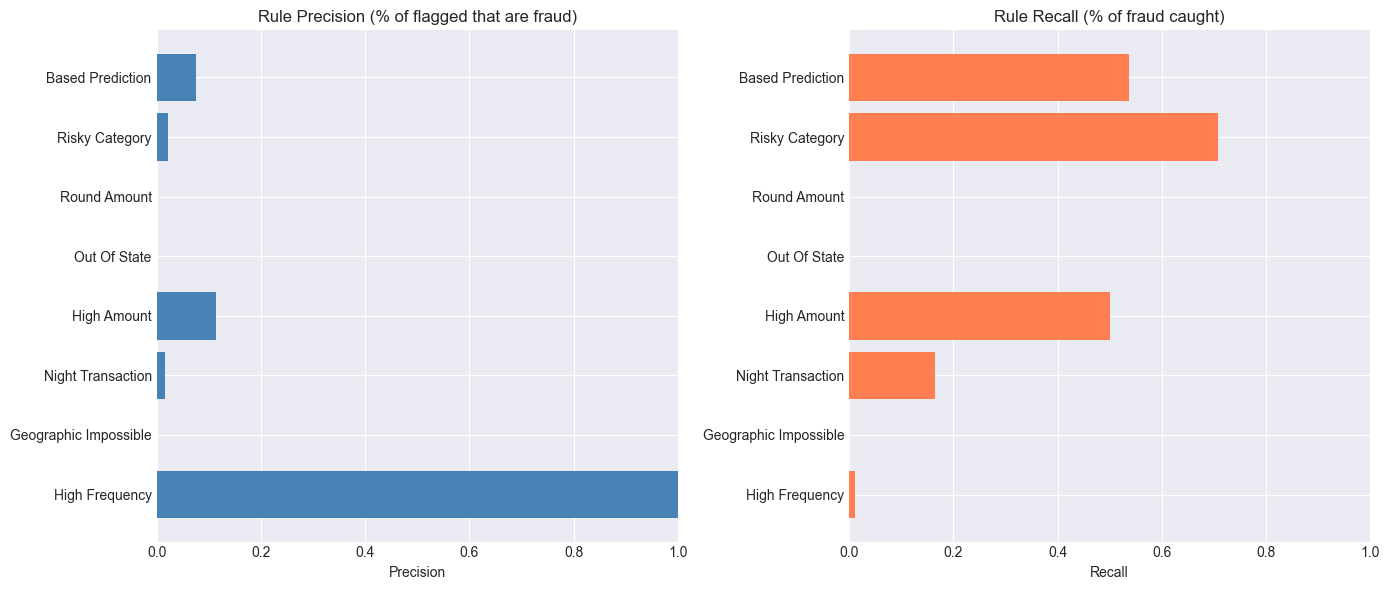

In [7]:
# Visualisierung: Precision & Recall pro Regel
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Nur einzelne Regeln (nicht COMBINED)
individual_rules = rule_performance[rule_performance['Rule'] != 'COMBINED (≥2 rules)'].copy()

# Precision
axes[0].barh(individual_rules['Rule'], individual_rules['Precision'], color='steelblue')
axes[0].set_xlabel('Precision')
axes[0].set_title('Rule Precision (% of flagged that are fraud)')
axes[0].set_xlim(0, 1)

# Recall
axes[1].barh(individual_rules['Rule'], individual_rules['Recall'], color='coral')
axes[1].set_xlabel('Recall')
axes[1].set_title('Rule Recall (% of fraud caught)')
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

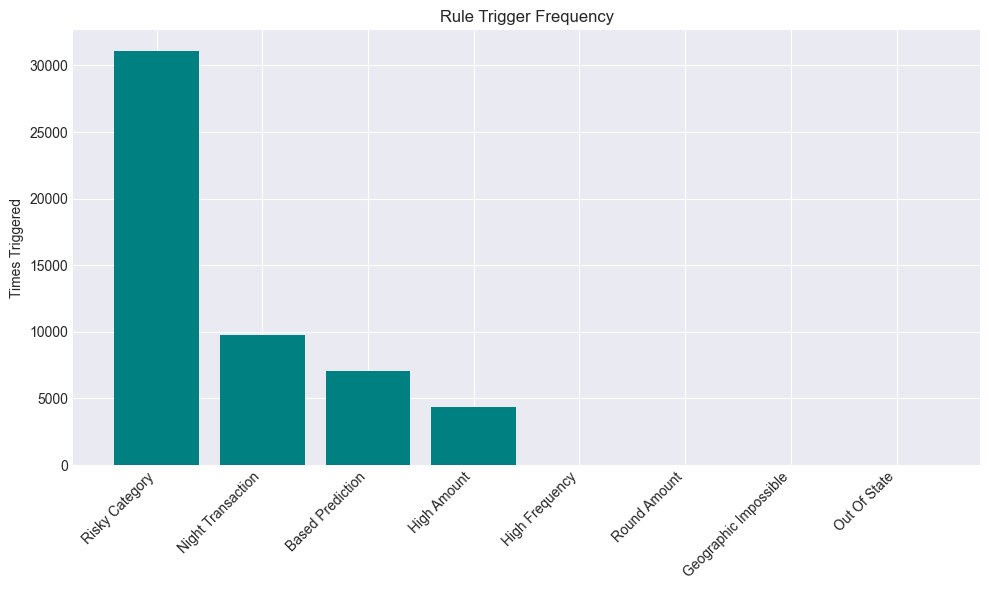


Rule Trigger Counts:
rule_risky_category           31081
rule_night_transaction         9740
rule_based_prediction          7025
rule_high_amount               4332
rule_high_frequency              12
rule_round_amount                12
rule_geographic_impossible        0
rule_out_of_state                 0
dtype: int64


In [8]:
# Welche Regeln werden am häufigsten getriggert?
trigger_counts = df_with_rules[rule_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(range(len(trigger_counts)), trigger_counts.values, color='teal')
plt.xticks(range(len(trigger_counts)), 
           [col.replace('rule_', '').replace('_', ' ').title() for col in trigger_counts.index],
           rotation=45, ha='right')
plt.ylabel('Times Triggered')
plt.title('Rule Trigger Frequency')
plt.tight_layout()
plt.show()

print("\nRule Trigger Counts:")
print(trigger_counts)

## 4. Combined Rule Performance

**Wie gut ist das System wenn wir Regeln kombinieren?**

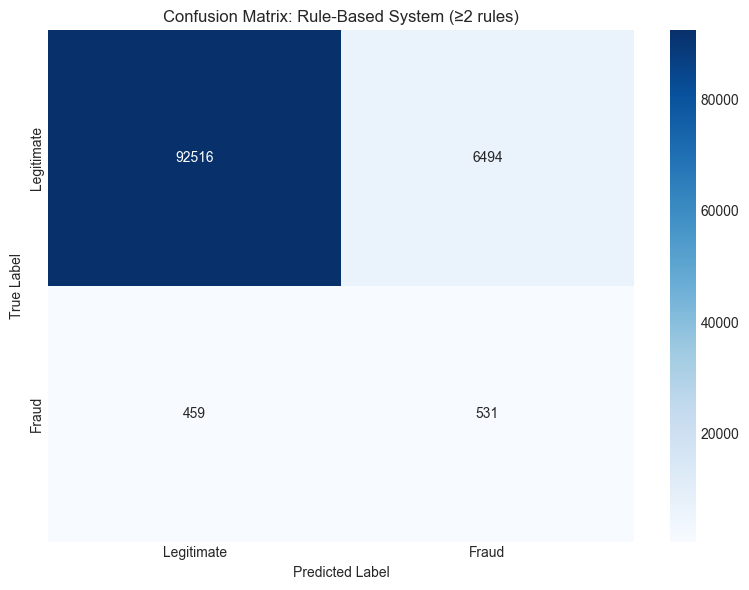


Confusion Matrix:
TN: 92,516 | FP: 6,494
FN: 459 | TP: 531


In [9]:
# Confusion Matrix für Combined Rules (≥2)
y_true = df_with_rules['is_fraud']
y_pred = df_with_rules['rule_based_prediction']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix: Rule-Based System (≥2 rules)')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(f"TN: {cm[0,0]:,} | FP: {cm[0,1]:,}")
print(f"FN: {cm[1,0]:,} | TP: {cm[1,1]:,}")

In [10]:
# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT: Rule-Based System")
print("="*60)
print(classification_report(y_true, y_pred, target_names=['Legitimate', 'Fraud']))


CLASSIFICATION REPORT: Rule-Based System
              precision    recall  f1-score   support

  Legitimate       1.00      0.93      0.96     99010
       Fraud       0.08      0.54      0.13       990

    accuracy                           0.93    100000
   macro avg       0.54      0.74      0.55    100000
weighted avg       0.99      0.93      0.96    100000



## 5. Threshold-Experimente

**Was passiert wenn wir Threshold ändern? (≥1, ≥2, ≥3 Regeln)**

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

threshold_results = []

for threshold in range(0, 8):
    y_pred_thresh = (df_with_rules['rules_triggered'] >= threshold).astype(int)
    
    precision = precision_score(y_true, y_pred_thresh, zero_division=0)
    recall = recall_score(y_true, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_true, y_pred_thresh, zero_division=0)
    
    flagged = y_pred_thresh.sum()
    flagged_pct = flagged / len(df_with_rules) * 100
    
    threshold_results.append({
        'Threshold': f'≥{threshold}',
        'Flagged': flagged,
        'Flagged_%': flagged_pct,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

threshold_df = pd.DataFrame(threshold_results)

print("\n" + "="*80)
print("THRESHOLD EXPERIMENTS")
print("="*80)
print(threshold_df.to_string(index=False))
print("="*80)


THRESHOLD EXPERIMENTS
Threshold  Flagged  Flagged_%  Precision   Recall  F1-Score
       ≥0   100000    100.000   0.009900 1.000000  0.019606
       ≥1    37854     37.854   0.020421 0.780808  0.039800
       ≥2     7025      7.025   0.075587 0.536364  0.132502
       ≥3      298      0.298   0.228188 0.068687  0.105590
       ≥4        0      0.000   0.000000 0.000000  0.000000
       ≥5        0      0.000   0.000000 0.000000  0.000000
       ≥6        0      0.000   0.000000 0.000000  0.000000
       ≥7        0      0.000   0.000000 0.000000  0.000000


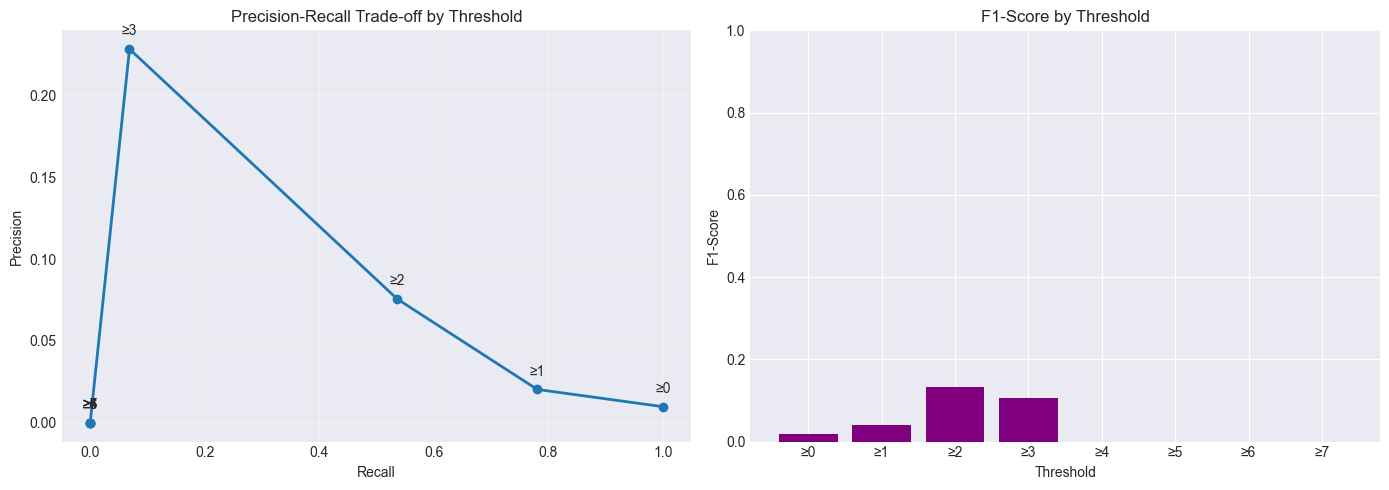

In [12]:
# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precision vs. Recall Trade-off
axes[0].plot(threshold_df['Recall'], threshold_df['Precision'], marker='o', linewidth=2)
for i, row in threshold_df.iterrows():
    axes[0].annotate(row['Threshold'], (row['Recall'], row['Precision']), 
                    textcoords="offset points", xytext=(0,10), ha='center')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Trade-off by Threshold')
axes[0].grid(True, alpha=0.3)

# F1-Score pro Threshold
axes[1].bar(threshold_df['Threshold'], threshold_df['F1-Score'], color='purple')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score by Threshold')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [13]:
# Bester Threshold?
best_threshold = threshold_df.loc[threshold_df['F1-Score'].idxmax()]

print("\n" + "="*60)
print("OPTIMAL THRESHOLD (by F1-Score)")
print("="*60)
print(f"Threshold: {best_threshold['Threshold']}")
print(f"Precision: {best_threshold['Precision']:.3f}")
print(f"Recall:    {best_threshold['Recall']:.3f}")
print(f"F1-Score:  {best_threshold['F1-Score']:.3f}")
print(f"Flagged:   {best_threshold['Flagged']:,.0f} ({best_threshold['Flagged_%']:.2f}%)")
print("="*60)


OPTIMAL THRESHOLD (by F1-Score)
Threshold: ≥2
Precision: 0.076
Recall:    0.536
F1-Score:  0.133
Flagged:   7,025 (7.03%)


## 6. Rule Insights

**Welche Regel-Kombinationen sind am stärksten?**

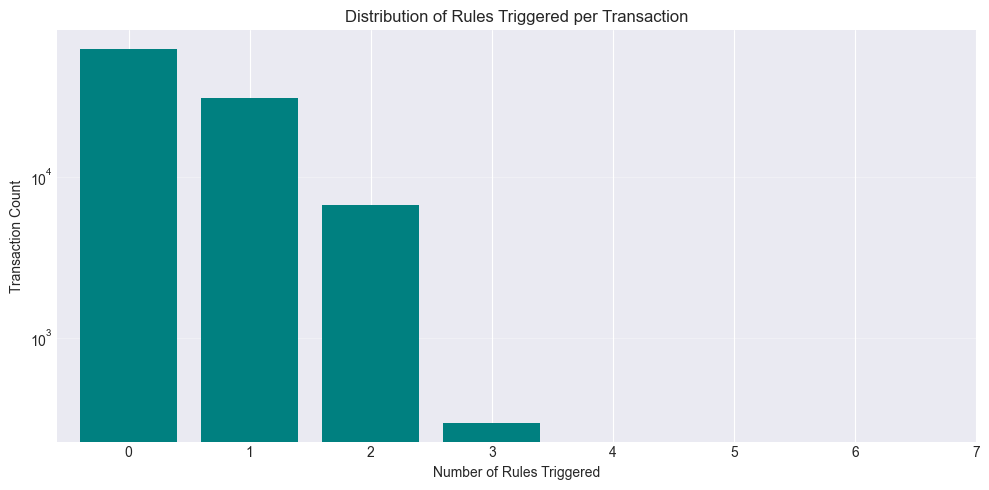


Rules Triggered Distribution:
rules_triggered
0    62146
1    30829
2     6727
3      298
Name: count, dtype: int64


In [14]:
# Verteilung: Wie viele Regeln werden getriggert?
rules_distribution = df_with_rules['rules_triggered'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(rules_distribution.index, rules_distribution.values, color='teal')
plt.xlabel('Number of Rules Triggered')
plt.ylabel('Transaction Count')
plt.title('Distribution of Rules Triggered per Transaction')
plt.xticks(range(8))
plt.yscale('log')  # Log scale wegen großer Unterschiede
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nRules Triggered Distribution:")
print(rules_distribution)

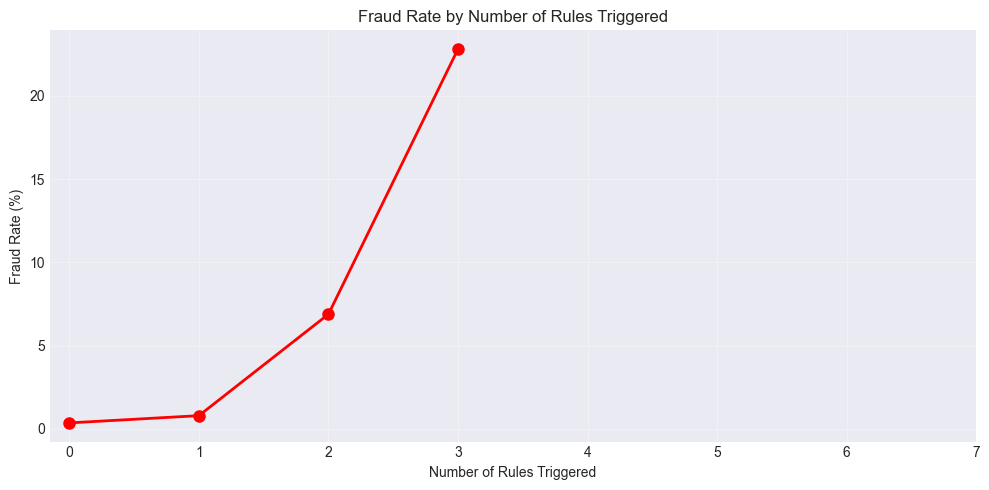


Fraud Rate by Rules Triggered:
                 Fraud_Count  Total  Fraud_Rate
rules_triggered                                
0                        217  62146    0.003492
1                        242  30829    0.007850
2                        463   6727    0.068827
3                         68    298    0.228188


In [15]:
# Fraud Rate nach Anzahl getriggerter Regeln
fraud_by_rules = df_with_rules.groupby('rules_triggered')['is_fraud'].agg(['sum', 'count', 'mean'])
fraud_by_rules.columns = ['Fraud_Count', 'Total', 'Fraud_Rate']

plt.figure(figsize=(10, 5))
plt.plot(fraud_by_rules.index, fraud_by_rules['Fraud_Rate'] * 100, 
         marker='o', linewidth=2, markersize=8, color='red')
plt.xlabel('Number of Rules Triggered')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Number of Rules Triggered')
plt.xticks(range(8))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFraud Rate by Rules Triggered:")
print(fraud_by_rules)

In [16]:
# Beispiele: High-Risk Transaktionen (viele Regeln getriggert)
high_risk = df_with_rules[df_with_rules['rules_triggered'] >= 4].head(10)

print("\nExample: High-Risk Transactions (≥4 rules triggered)")
print("="*80)
for idx, row in high_risk.iterrows():
    print(f"\nTransaction #{row['trans_num']}")
    print(f"  Amount: ${row['amt']:.2f}")
    print(f"  Category: {row['category']}")
    print(f"  Time: {row['trans_date_trans_time']}")
    print(f"  Actual Fraud: {'YES' if row['is_fraud'] == 1 else 'NO'}")
    print(f"  Rules Triggered: {row['rules_triggered']}/7")
    
    # Welche Regeln?
    triggered_rules = [col.replace('rule_', '').title() for col in rule_cols if row[col] == 1]
    print(f"  → {', '.join(triggered_rules)}")
    print("-"*80)


Example: High-Risk Transactions (≥4 rules triggered)


## 7. Daten speichern für ML

**Speichere DataFrame mit Regeln für nächsten Schritt (ML Training)**

In [17]:
# Speichere verarbeitete Daten
output_path = '../data/processed/transactions_with_rules.csv'
df_with_rules.to_csv(output_path, index=False)

print(f"\n✓ Saved {len(df_with_rules):,} transactions to:")
print(f"  {output_path}")
print(f"\nColumns: {len(df_with_rules.columns)}")
print(f"File size: {df_with_rules.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


✓ Saved 100,000 transactions to:
  ../data/processed/transactions_with_rules.csv

Columns: 38
File size: 90.9 MB


## Summary & Next Steps

In [18]:
# Finale Summary
combined_perf = rule_performance[rule_performance['Rule'] == 'COMBINED (≥2 rules)'].iloc[0]

print("\n" + "="*80)
print("RULE-BASED SYSTEM SUMMARY")
print("="*80)
print(f"\nDataset: {len(df_with_rules):,} transactions")
print(f"Fraud Rate: {df_with_rules['is_fraud'].mean():.2%}")
print(f"\nRules: 7 business rules")
print(f"Decision: ≥2 rules triggered → Fraud")
print(f"\nPerformance:")
print(f"  Precision: {combined_perf['Precision']:.3f} ({combined_perf['Precision']:.1%})")
print(f"  Recall:    {combined_perf['Recall']:.3f} ({combined_perf['Recall']:.1%})")
print(f"  F1-Score:  {combined_perf['F1_Score']:.3f}")
print(f"\nFlagged: {combined_perf['Triggered']:,.0f} transactions")
print(f"Fraud Found: {combined_perf['Fraud_Found']:,.0f}")
print("\n" + "="*80)
print("Next: Train ML model and compare with Rule-Based!")
print("→ Notebook: 03_model_training.ipynb")
print("="*80)


RULE-BASED SYSTEM SUMMARY

Dataset: 100,000 transactions
Fraud Rate: 0.99%

Rules: 7 business rules
Decision: ≥2 rules triggered → Fraud

Performance:
  Precision: 0.076 (7.6%)
  Recall:    0.536 (53.6%)
  F1-Score:  0.133

Flagged: 7,025 transactions
Fraud Found: 531

Next: Train ML model and compare with Rule-Based!
→ Notebook: 03_model_training.ipynb
